# 0 Background

In order to obtain the Master Information Block (MIB) and System Information Block (SIB) messages sent by the Base Station via the Physical Broadcast Channel (PBCH), the User Equipment (UE) must search for the Primary Synchronization Signal (PSS) in both frequency and time domains.

In 5G baseband chips, parallel search modules are employed to synchronize with PSS signals in multiple frequency bands simultaneously. However, implementing this synchronization module in a general-purpose spectrum analyzer can be challenging. To address this limitation, I propose a novel fast cross-correlation module that enhances PSS searching efficiency and allows for easy exploitation of Graphics Processing Units (GPUs) for parallelized searching.


## 1 Principle

From a technical perspective, traditional discrete cross-correlation algorithms typically exhibit an $O(N^2)$ complexity. However, by leveraging Fast Fourier Transform (FFT), we can efficiently calculate the equivalent result of cross-correlation with a significantly reduced computational complexity.

$$
R_{xy}[k] = \sum_{n=0}^{M-1} x[n] \cdot y[n+k]
$$

FFT-based cross-correlation:

$$
\begin{aligned}
    R_{xy}[k] &= x[n] * y[-n] \\
            &= \text{IFFT}(\text{FFT}(x[n]) \cdot \text{FFT}(y[-n])) \\
            &= \text{IFFT}(\text{FFT}(x[n]) \cdot \text{conj}(\text{FFT}(y[n])))
\end{aligned}
$$

By leveraging the frequency shift property of Fourier Transform, shifting the reference signal after FFT is equivalent to searching for the PSS at different frequency points. This allows us to efficiently search for PSS in specific frequency positions by simply shifting the frequency domain sequence.

In [1]:
import os
gpu_num = 0  # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

# Import Sionna
import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import scipy
import numpy as np
from sionna.ofdm import OFDMModulator

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def ofdm_modulate_helper(grid, Nfft, cp_len=0):
    """
    This helper function converts the OFDM modulation from a resource block (RB) perspective to a NFFT perspective, facilitating more efficient processing and analysis.

    Args:
        grid (tf.Tensor): The frequency-time grid has a size of NRBx12-by-NSymbols,
                          where NRB represents the number of resource blocks and NSymbols is the number of symbols.
        Nfft (int): size of FFT
        cp_len (int, optional): Cyclic prefix. Defaults to 0.

    Returns:
        tf.Tensor: waveform
    """
    ofdm_modulator = OFDMModulator(cp_len)
    Npadding = (Nfft - grid.shape[-1]) // 2
    paddings = []
    for i in range(len(grid.shape) - 1):
        paddings.append([0, 0])
    paddings.append([Npadding, Nfft - grid.shape[-1] - Npadding])
    grid_padding = tf.pad(grid, tf.constant(paddings), 'CONSTANT')
    return ofdm_modulator(grid_padding)

class PssSearch:
    """
    PSS search module, operation in time and frequency domain.
    """
    def __init__(self, fc, bw, scs, data_len):
        """
        PSS search module, operation in time and frequency domain.

        Args:
            fc (float): carrier frequency
            bw (int): bandwidth in MHz
            scs (int): sub carrier spacing in kHz
            data_len (int): length of data to search
        """
        self.fc = fc
        self.bw = bw
        self.scs = scs
        self.NRB = self.NRB_table(self.bw, self.scs)
        self.Nfft, self.cp_len = self.ofdm_info(self.bw, self.scs)
        print(f'NRB={self.NRB}, Nfft={self.Nfft}, cp_len={self.cp_len}')
        self.data_len = data_len
        self.osf = int(data_len / self.Nfft)

        self.prepare_pss()

    def __call__(self, waveform):
        strategy = tf.distribute.MirroredStrategy()
        with strategy.scope():
            waveform_f = tf.signal.fft(waveform)
            print(f'len of waveform_f: {len(waveform_f)}')
            max_value = self.compute_max_shifted_ifft(waveform_f, self.pss_padding_f, self.search_k_span)
            f_pos = tf.argmax(max_value)
            print(f'Find PSS at k={self.search_k_scs_span[f_pos]}, '
                  f'GSCN frequency:{self.search_gscn_freq[f_pos]}, GSCN: {self.search_gscn_num[f_pos]}')
            xcorr_r = self.fast_search_once(waveform_f, self.pss_padding_f, self.search_k_span[f_pos])
            t_pos = tf.argmax(tf.abs(xcorr_r))
            res = {
                'max_idx': f_pos,
                'ssb_at_GSCN': self.search_gscn_num[f_pos],
                'ssb_at_frequency': self.search_gscn_freq[f_pos],
                'xcorr_vs_span': max_value.numpy(),
                'search_span': self.search_k_scs_span,
                'xcorr': xcorr_r.numpy(),
                'ssb_t_pos': t_pos,
            }
        return res

    def prepare_pss(self):
        pss_f = self.pss(0)
        print(f'len of pss_f: {pss_f.shape}')
        pss_t = self.pss_wave(pss_f)
        self.pss_padding_f = self.pss_padding_fft(pss_t, self.data_len)
        self.search_k_span = self.get_search_k_span()
        print(f'len of self.search_k_span: {len(self.search_k_span)}')

    def fast_search_once(self, waveform_f, pss_f_padding, shift):
        def circular_shift(x, shift):
            return tf.concat([x[-shift:], x[:-shift]], axis=0)

        shifted_vector = circular_shift(pss_f_padding, shift)
        multiplied = shifted_vector * waveform_f
        ifft_result = tf.signal.ifft(tf.cast(multiplied, tf.complex64))
        return ifft_result

    def compute_max_shifted_ifft(self, waveform_f, pss_padding_f, span):
        shifts = span
        def compute_for_shift(shift):
            ifft_result = self.fast_search_once(waveform_f, pss_padding_f, shift)
            print(f'shift={shift}')
            return tf.reduce_max(tf.abs(ifft_result))

        results = tf.map_fn(compute_for_shift, shifts, dtype=tf.float32)

        # results = []
        # for shift in shifts:
        #     r = compute_for_shift(shift)
        #     results.append(r)
        return results

    def pss_padding_fft(self, pss_t, data_len):
        b_padded = tf.pad(pss_t, [[0, data_len - len(pss_t)]], mode='CONSTANT')
        b_fft = tf.math.conj(tf.signal.fft(b_padded))
        return b_fft


    def pss(self, id):
        pss_seq = [
          [1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1,
            -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1,
            -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1,
            1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1,
            -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1,
            -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1,
            -1, 1, -1, 1, 1, 1, 1, -1],
          [1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1,
            1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1,
            1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1,
            1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1,
            1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1,
            -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1,
            1, -1, 1, -1, -1, -1, 1, -1],
          [-1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1,
            1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1,
            1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1,
            1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1,
            -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1,
            1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1,
            -1, -1, -1, 1, 1, 1, 1, -1],
        ]
        return np.array(pss_seq[id])

    def pss_wave(self, pss_f, koffset=0):
        ind = np.arange(56, 56+127)
        grid = np.zeros((self.NRB*12,))
        grid[ind+koffset] = pss_f
        tf_grid = tf.convert_to_tensor(np.expand_dims(grid, axis=0), dtype=tf.complex128)
        pss_t = ofdm_modulate_helper(tf_grid, self.Nfft)
        return pss_t

    def get_search_k_span(self):
        def GSCN_0_3000(M):
            N = np.arange(1, 2499+1, dtype=np.int32)
            gscn_freq = N*1200 + M*50
            gscn_num = 3*N+(M-3)//2
            return gscn_freq, gscn_num

        f0_kHz = int(round(self.fc / 1000))
        k_scs = np.arange(-self.NRB*12//2, self.NRB*12//2, dtype=np.int32)
        f_scs = k_scs * self.scs + f0_kHz

        for m in [1, 3, 5]:
            gscn_freq, gscn_num = GSCN_0_3000(m)
            comm_elem = np.intersect1d(f_scs, gscn_freq)
            print(f'gscn m={m}, comm_elems: {comm_elem}')
            if len(comm_elem) > 0:
                scs_idx = np.where(np.isin(f_scs, comm_elem))
                print(scs_idx)
                tmp_freq = f_scs[scs_idx]
                tmp_k_scs = k_scs[scs_idx]
                print(tmp_k_scs)
                gscn_idx = np.where(np.isin(gscn_freq, comm_elem))
                self.search_gscn_freq = comm_elem
                self.search_gscn_num = gscn_num[gscn_idx]
                self.search_k_scs_span = tmp_k_scs + self.NRB*12//2 - 120  # GSCN freq at ceter of SSB, offset -120 to align left sc.
                print(self.search_k_scs_span)
                break

        span = self.search_k_scs_span
        print(f'search {len(span)} frequency points')
        return span * self.osf

    def ofdm_info(self, bw, scs):
        tb = {
            # bw, scs: Nfft, cp_len
            (100, 30): (4096, [352] + [288]*13)
        }
        return tb.get((bw, scs))

    def NRB_table(self, bw, scs):
        tb = {
            # bw, scs: NRB
            (5, 15): 25,
            (10, 15): 52,
            (15, 15): 79,
            (20, 15): 106,
            (25, 15): 133,
            (30, 15): 160,
            (35, 15): 188,
            (40, 15): 216,
            (45, 15): 242,
            (50, 15): 270,
            (5, 30): 11,
            (10, 30): 24,
            (15, 30): 38,
            (20, 30): 51,
            (25, 30): 65,
            (30, 30): 78,
            (35, 30): 92,
            (40, 30): 106,
            (45, 30): 119,
            (50, 30): 133,
            (60, 30): 162,
            (80, 30): 217,
            (90, 30): 245,
            (100, 30): 273,
        }
        return tb.get((bw, scs))


# 3 Searching result


In [4]:

# Load received signals
home_path = './'
mat_data = scipy.io.loadmat(os.path.join(home_path, 'ssb.mat'))

# prepare data
waveform = mat_data['waveform']
waveform_tf = tf.convert_to_tensor(waveform[:, -1])

print(f'waveform: {waveform.shape}')

# Initiate search module
pss_search = PssSearch(2524.85e6, 100, 30, 1228800*2)

waveform: (2457600, 1)
NRB=273, Nfft=4096, cp_len=[352, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288]
len of pss_f: (127,)
gscn m=1, comm_elems: [2476850 2478050 2479250 2480450 2481650 2482850 2484050 2485250 2486450
 2487650 2488850 2490050 2491250 2492450 2493650 2494850 2496050 2497250
 2498450 2499650 2500850 2502050 2503250 2504450 2505650 2506850 2508050
 2509250 2510450 2511650 2512850 2514050 2515250 2516450 2517650 2518850
 2520050 2521250 2522450 2523650 2524850 2526050 2527250 2528450 2529650
 2530850 2532050 2533250 2534450 2535650 2536850 2538050 2539250 2540450
 2541650 2542850 2544050 2545250 2546450 2547650 2548850 2550050 2551250
 2552450 2553650 2554850 2556050 2557250 2558450 2559650 2560850 2562050
 2563250 2564450 2565650 2566850 2568050 2569250 2570450 2571650 2572850]
(array([  38,   78,  118,  158,  198,  238,  278,  318,  358,  398,  438,
        478,  518,  558,  598,  638,  678,  718,  758,  798,  838,  878,
        918,  958,  998, 1038, 

In [5]:
# Perform the search
res = pss_search(waveform_tf)

len of waveform_f: 2457600
shift=-49200
shift=-25200
shift=-1200
shift=22800
shift=46800
shift=70800
shift=94800
shift=118800
shift=142800
shift=166800
shift=190800
shift=214800
shift=238800
shift=262800
shift=286800
shift=310800
shift=334800
shift=358800
shift=382800
shift=406800
shift=430800
shift=454800
shift=478800
shift=502800
shift=526800
shift=550800
shift=574800
shift=598800
shift=622800
shift=646800
shift=670800
shift=694800
shift=718800
shift=742800
shift=766800
shift=790800
shift=814800
shift=838800
shift=862800
shift=886800
shift=910800
shift=934800
shift=958800
shift=982800
shift=1006800
shift=1030800
shift=1054800
shift=1078800
shift=1102800
shift=1126800
shift=1150800
shift=1174800
shift=1198800
shift=1222800
shift=1246800
shift=1270800
shift=1294800
shift=1318800
shift=1342800
shift=1366800
shift=1390800
shift=1414800
shift=1438800
shift=1462800
shift=1486800
shift=1510800
shift=1534800
shift=1558800
shift=1582800
shift=1606800
shift=1630800
shift=1654800
shift=1678800


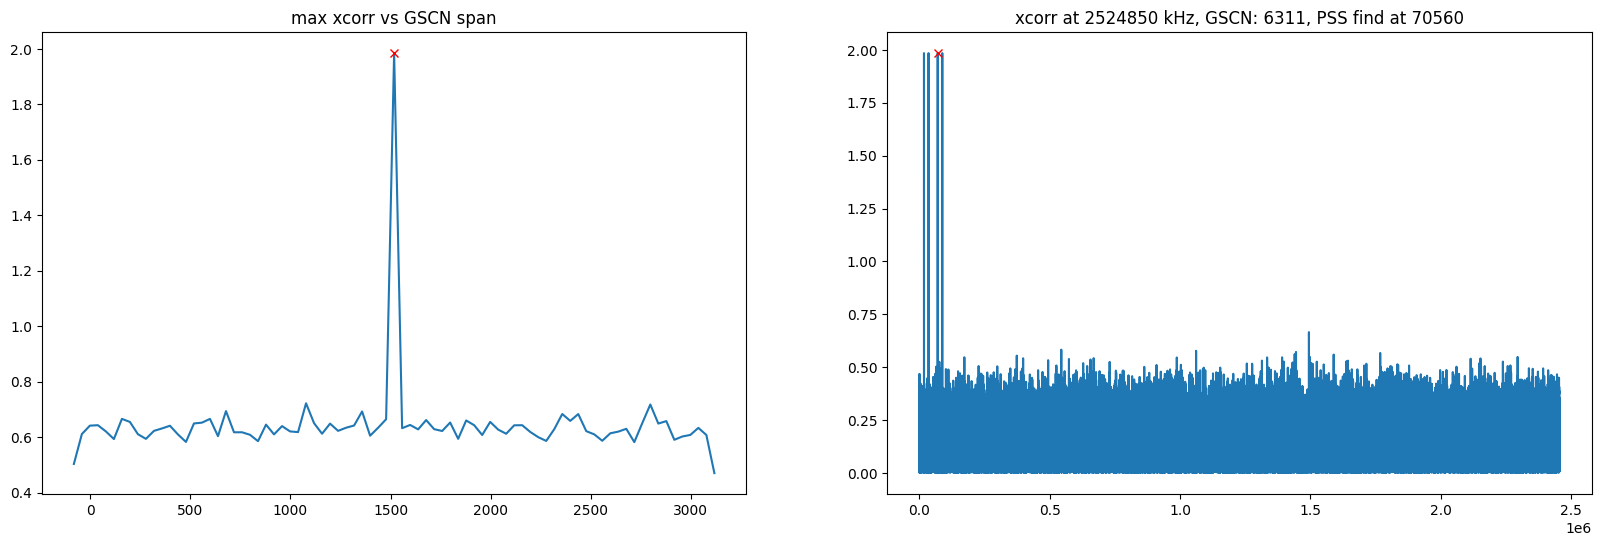

In [6]:
# Extract results
k_scs = res['search_span']
pss_f_pos = res['xcorr_vs_span']
xcorr_r = res['xcorr']
ssb_freq = res['ssb_at_frequency']

# Plot results
plt.figure(figsize=[20, 6])

plt.subplot(1, 2, 1)
plt.plot(k_scs, pss_f_pos)
plt.plot(k_scs[res["max_idx"]], pss_f_pos[res["max_idx"]], 'rx')
plt.title('max xcorr vs GSCN span')

plt.subplot(1, 2, 2)
plt.plot(np.abs(xcorr_r))
plt.plot(res["ssb_t_pos"], np.abs(xcorr_r)[res["ssb_t_pos"]], 'rx')
plt.title(f'xcorr at {ssb_freq} kHz, GSCN: {res["ssb_at_GSCN"]}, PSS find at {res["ssb_t_pos"]}')

plt.show()